# Pole Test Code

__Author: Tim Arthur__

__Date: 8th Nov 2022__

## Introduction
This notebook explains step by step how this pole test has been designed.

The idea, is that we compare the centre of pressure values from the force plates, with coordinates calculated from a marker defined line that intersects the floor.

This is the pole that is being used:

## The code:
The code is written using python 3.7

We are using the Pandas, Numpy, Matplotlib and scipy data analytics libraries for this code

So far, I have only tested the code from the Jupyter Lab terminal. To run the code from Nexus I may need to make some small changes, such as adding specific paths to the code so that python runs properly.

Step 1: import all the required libraries

In [1]:
from viconnexusapi import ViconNexus
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

vicon = ViconNexus.ViconNexus()

Step 2: Get all the data required from Nexus. Force Plate 1 and 2 are perpendicular to one another, so for one of the force plates, the x and y components have been swapped around.

In [2]:
#remember coordinates of FP 1 and 2 are rotated 90deg
COP1y, ready, rate = vicon.GetDeviceChannel(6,3,1)
COP1x, ready, rate = vicon.GetDeviceChannel(6,3,2)
COP1z, ready, rate = vicon.GetDeviceChannel(6,3,3)
COP2x, ready, rate = vicon.GetDeviceChannel(7,3,1) # note this and
COP2y, ready, rate = vicon.GetDeviceChannel(7,3,2) # this are swapped around intentionally
COP2z, ready, rate = vicon.GetDeviceChannel(7,3,3)

Fz_FP1, ready, rate = vicon.GetDeviceChannel(6,1,3)
Fz_FP2, ready, rate = vicon.GetDeviceChannel(7,1,3)

Step 3: Move the data into a Pandas dataframe, which will increase processing speed and simplicity.

The marker data is collected at 100Hz, whereas the force plate data is collected at 1000Hz. Therefore, to ensure each data series is the same length, the forceplate data is sampled at every 10th point.

In [3]:
arr_leng = len(COP1x)
df = pd.DataFrame({
    'COP1x' :COP1x[:arr_leng:10],
    'COP1y' :COP1y[:arr_leng:10],
    'COP1z' :COP1z[:arr_leng:10],
    'COP2x' :COP2x[:arr_leng:10],
    'COP2y' :COP2y[:arr_leng:10],
    'COP2z' :COP2z[:arr_leng:10]
})

Step 4: Get the markers' trajectories and validate which are the correct marker groups - i.e. which are the ones at the top and which are at the bottom of the pole.

In [4]:
medians = []
for x in range(vicon.GetUnlabeledCount()):
    trajX, trajY, trajZ, trajExists = vicon.GetUnlabeled(x)
    df_labelx = 'trajX' + str(x)
    df_labely = 'trajY' + str(x)
    df_labelz = 'trajZ' + str(x)
    df[df_labelx] = trajX
    df[df_labely] = trajY
    df[df_labelz] = trajZ
    
    medians.append(np.median(df[df_labelz]))
    
medians = pd.Series(medians)
medians.sort_values(ascending=False)
higher_markers_indexs = medians.nlargest(4).index # The 4 highest medians of the marker trajectories in the z direction, correspond to the top markers (highest 2 medians) 
# and the bottom markers (2nd highest 2 medians)

The 1st and 2nd highest medians should mean that these marker trajectories are part of the top group of markers, and the 3rd and 4th highest medians should mean that these marker trajectories are part of the bottom group of markers.

Step 5: Filter the data. There should be 2 filters. One for the force plate data and another for marker trajectory data

In [5]:
fs = 100
N = df.shape[0]
cutoff = [10, 15]
nyq = 0.5 * fs
order = [2, 2]

normal_cutoff_COP = cutoff[0] / nyq
normal_cutoff_traj = cutoff[1] / nyq

b, a = butter(order[0], normal_cutoff_COP, btype='low', analog=False) # filter for force plate data
d, c = butter(order[1], normal_cutoff_traj, btype='low', analog=False) # filter for marker trajectory data

for col in df.columns:
    if 'COP' in col:
        df[col] = filtfilt(b, a, df[col])
    if 'traj' in col:
        df[col] = filtfilt(d, c, df[col])

Step 6: Find the midpoint between the top 2 markers, and the midpoint between the bottom 2 markers.

In [6]:
#top group
base_label_names = ['trajX', 'trajY', 'trajZ']
df_labels = []
for x in higher_markers_indexs: #this variable is defined in step 4
    for y in base_label_names:
        #this will give the correct label i.e. 'trajX0' or 'trajX3'
        label = y + str(x)
        df_labels.append(label)

# because of the way the data was sorted above, the order of the labels will always be defined in the same way
df['midXtop'] = ( df[df_labels[0]] + df[df_labels[3]] ) / 2
df['midYtop'] = ( df[df_labels[1]] + df[df_labels[4]] ) / 2
df['midZtop'] = ( df[df_labels[2]] + df[df_labels[5]] ) / 2

df['midXbot'] = ( df[df_labels[6]] + df[df_labels[9]] ) / 2
df['midYbot'] = ( df[df_labels[7]] + df[df_labels[10]] ) / 2
df['midZbot'] = ( df[df_labels[8]] + df[df_labels[11]] ) / 2    


Step 7: Calcuate the equation of the line between these 2 mid-points, and use this to find the x and y coordinates of the point along this line where z = 0 - i.e. where the line intersects the floor. Also, calculate the distance between these 2 points.

Equation of a line in 3D between 2 points:

_(x – x1)/(x2 - x1) = (y – y1)/(y2 - y1) = (z – z1)/(z2 - z1)_

_x coordinte: x  = ((x2 - x1)*(0 – z1)/(z2 - z1)) + x1_

_y coordinte: y  = ((y2 - y1)*(0 – z1)/(z2 - z1)) + y1_

In [7]:
df['diffX'] = df['midXtop'] - df['midXbot']
df['diffY'] = df['midYtop'] - df['midYbot']
df['diffZ'] = df['midZtop'] - df['midZbot']

df['xcoord'] = ((df['diffX'] * -1 * df['midZbot'])/(df['diffZ'])) + df['midXbot']
df['ycoord'] = ((df['diffY'] * -1 * df['midZbot'])/(df['diffZ'])) + df['midYbot']

df['distance_between_Markers'] = (((df['diffX'])**2)+((df['diffY'])**2)+((df['diffZ'])**2))**0.5

Step 8: Apply the correct gain and offsets to the force plate data, so that it corresponds to the global coordinate system that the markers exist in.

These can be seen when looking at x, y and z components of the force plates in the 'Graph' view on Nexus. Note at the start, that the values are not equal to 0 in some cases.

![](Force_Plate_Offsets.png)

Therefore, we need to offset the CoP coordinates of the force plate

For force plate 1:

x needs to be offset by + 300

y needs to be flipped and offset by - 200

For force plate 2:

x needs to be flipped and offset by + 200

y needs to be flipped and offset by + 300

In [8]:
df['COP1x'] = df['COP1x'] + 300
df['COP1y'] = ( df['COP1y'] * -1 ) - 200
df['COP2x'] = ( df['COP2x'] * -1 ) + 200
df['COP2y'] = ( df['COP2y'] * -1 ) + 300

Lets check everything is looking good.

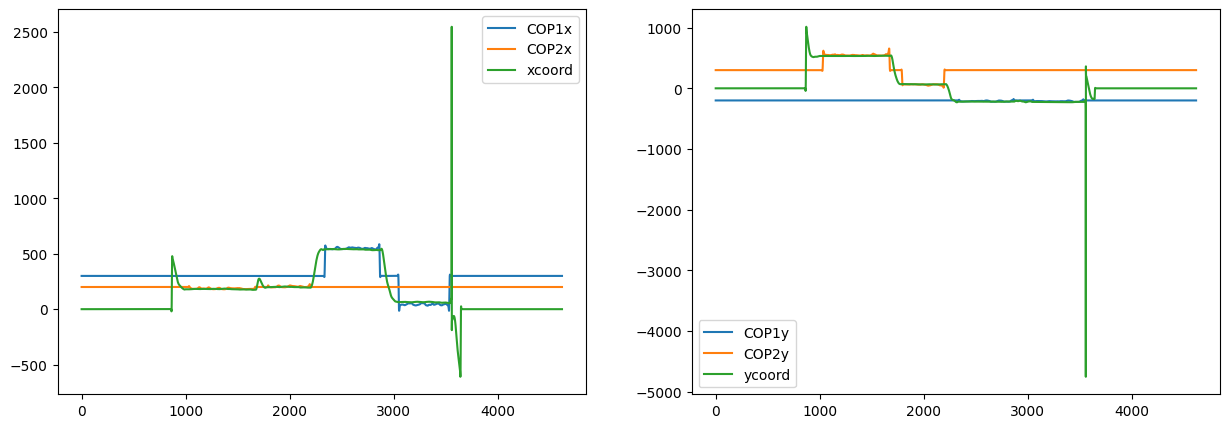

In [9]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(df['COP1x'], label='COP1x')
axs[0].plot(df['COP2x'], label='COP2x')
axs[0].plot(df['xcoord'], label='xcoord')
axs[0].legend()
axs[1].plot(df['COP1y'], label='COP1y')
axs[1].plot(df['COP2y'], label='COP2y')
axs[1].plot(df['ycoord'], label='ycoord')
axs[1].legend()
fig.set_figwidth(15)
fig.set_figheight(5)

Step 9: Compare the data. Find the steps to begin with (where the pole was being pushed into the force plate). This can be identified through the Fz component from the force plates - when this is not 0.

In [10]:
Fz_FP1 = np.array(Fz_FP1[:arr_leng:10])
Fz_FP2 = np.array(Fz_FP2[:arr_leng:10])

base_labels = ['COP1y', 'COP1x', 'COP2y', 'COP2x', 'ycoord', 'xcoord']
no_of_steps_FP1 = 0
no_of_steps_FP2 = 0
#start with force plate 1
for label in base_labels:
    if '1' in label:
        idx = np.where(Fz_FP1 != 0)[0]
        split_array = np.split(df[label][idx],np.where(np.diff(idx)!=1)[0]+1) # This bit of code will split the data series into a multiple arrays, using the sections where Fz = 0 as the splitting marker
        no_of_steps = len(split_array)
        no_of_steps_FP1 = no_of_steps
        for step in range(no_of_steps):
            step_label = label + '_step' + str(step)
            df[step_label] = np.split(df[label][idx],np.where(np.diff(idx)!=1)[0]+1)[step] #This bit of code will assign each split array to its own data series with an identifiable name
            
    elif '2' in label:
        idx = np.where(Fz_FP2 != 0)[0]
        split_array = np.split(df[label][idx],np.where(np.diff(idx)!=1)[0]+1)
        no_of_steps = len(split_array)
        no_of_steps_FP2 = no_of_steps
        for step in range(no_of_steps):
            step_label = label + '_step' + str(step)
            df[step_label] = np.split(df[label][idx],np.where(np.diff(idx)!=1)[0]+1)[step]
    else:
        idx = np.where(Fz_FP1 != 0)[0]
        split_array = np.split(df[label][idx],np.where(np.diff(idx)!=1)[0]+1)
        no_of_steps = len(split_array)
        for step in range(no_of_steps):
            step_label = label + '_FP1_step' + str(step)
            df[step_label] = np.split(df[label][idx],np.where(np.diff(idx)!=1)[0]+1)[step]
        idx = np.where(Fz_FP2 != 0)[0]
        split_array = np.split(df[label][idx],np.where(np.diff(idx)!=1)[0]+1)
        no_of_steps = len(split_array)
        for step in range(no_of_steps):
            step_label = label + '_FP2_step' + str(step)
            df[step_label] = np.split(df[label][idx],np.where(np.diff(idx)!=1)[0]+1)[step]

Step 10: Compare the force plate steps to the trajectory steps by using the root mean squared error

In [11]:
RMS_values = []
RMS_labels = []
COP_label_names = ['COP1y_step', 'COP1x_step', 'COP2y_step', 'COP2x_step']
coord_label_names = ['ycoord_FP1_step', 'xcoord_FP1_step', 'ycoord_FP2_step', 'xcoord_FP2_step']
for x in range(4):
    for step in range(no_of_steps_FP1):
        COP_label = COP_label_names[x] + str(step)
        coord_label = coord_label_names[x] + str(step)
    
        MSE = (np.square(np.subtract(df[COP_label],df[coord_label]))).mean() #mean squared error
        RMS_values.append(MSE ** 0.5) #root mean squared error
        RMS_labels.append(COP_label + '___' + coord_label)
    
results = pd.Series(data=RMS_values, index=RMS_labels)

Now the results can be output. This should include the distance between the markers and the RMS error of the COP values.

I plan on using an acceptable error is deamed as 20mm for the force plates - this accounts for defects in the placement of the markers, which are not perfectly orientated and the noise in the force plate signal, which is larger because the force exerted during the pole test is small.

I have not yet decided how or where I am going to output these results. That is still to do.